## ECG Heartbeat Categorization Machine Learning

In [1]:
# Initialize libaries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from model_definitions import stanford_resnet
from data_processing import load_data

from collections import Counter

Load in ECG Heartbeat Categorization Datasets
   - The final element of each row denotes which class that samples belongs
   - Samples are padded with zeros at the end to normalize sample sizes

In [2]:
# Loading data in through Pandas, faster than numpy for dataset of this size
data1, data1_labels = load_data("./archive/mitbih_test.csv")
print(data1.shape)

(21892, 187)


Now that the data is separated, start with some analysis.

    - N: Normal Beat
    - S: Supraventricular premature beat
    - V: Premature ventricular contraction
    - F: Fusion of ventricular and normal beat
    - Q: Unclassifiable beat

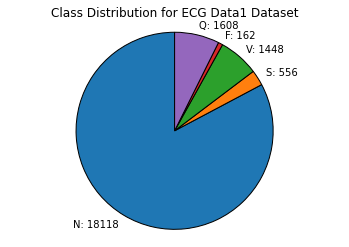

In [3]:
# Check class balance
classes = {0:'N', 1:'S', 2:'V', 3:'F', 4:'Q'}

class_counts = Counter(data1_labels)
sizes = []
labels = []
for key in class_counts:
    sizes.append(class_counts[key])
    labels.append(classes[key]+": "+"{}".format(class_counts[key]))
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, startangle=90,
        wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Class Distribution for ECG Data1 Dataset')
plt.show()

Normal Heartbeats are represented much higher in the dataset than the other classes. Typically, class balance is important to make sure the model does not get too biased towards classifying the majority class. There are a few different ways to implement this balance.

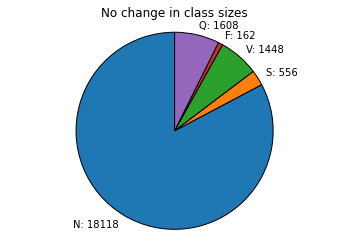

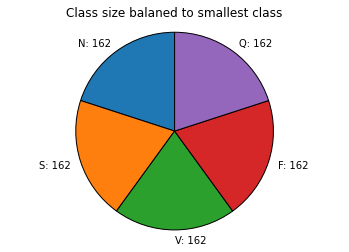

In [4]:
# No change in class sizes
# data1, data1_labels remain unchanged
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, startangle=90,
        wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('No change in class sizes')
plt.show()

# Class sizes limited to size of smallest class
lowest = class_counts[min(class_counts, key=class_counts.get)]
data1_reduced = np.empty((0,data1.shape[1]))
data1_labels_reduced = np.empty((0))
for label in np.unique(data1_labels):
    label_indices = np.where(data1_labels==label)
    label_indices_reduced = np.random.choice(label_indices[0], lowest, replace=False)
    
    temp_data     = data1[label_indices_reduced]
    temp_labels   = data1_labels[label_indices_reduced]
    data1_reduced = np.append(data1_reduced, temp_data, axis=0)
    data1_labels_reduced = np.append(data1_labels_reduced, temp_labels, axis=0)

class_counts1 = Counter(data1_labels_reduced)
sizes1  = []
labels1 = []
for key in class_counts1:
    sizes1.append(class_counts1[key])
    labels1.append(classes[key]+": "+"{}".format(class_counts1[key]))
    
fig2, ax2 = plt.subplots()
ax2.pie(sizes1, labels=labels1, startangle=90,
        wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Class size balaned to smallest class')
plt.show()


Now that there are a few different sets of data available for training, load in the machine learning model and begin training.

In [5]:
# Load in model
input_shape = (187,1) # Number of channels per input is 1
num_classes = len(np.unique(data1_labels))
num_blocks  = 3

model = stanford_resnet(input_shape, num_classes, 3)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 187, 32)      192         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 187, 32)     128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 187, 32)      0           ['batch_normalization[0][0]']

 batch_normalization_7 (BatchNo  (None, 187, 32)     128         ['conv1d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_7 (Activation)      (None, 187, 32)      0           ['batch_normalization_7[0][0]']  
                                                                                                  
 dropout_6 (Dropout)            (None, 187, 32)      0           ['activation_7[0][0]']           
                                                                                                  
 conv1d_8 (Conv1D)              (None, 187, 32)      5152        ['dropout_6[0][0]']              
                                                                                                  
 max_pooling1d_3 (MaxPooling1D)  (None, 187, 32)     0           ['add_2[0][0]']                  
          

In [6]:
# Train model on first configuration
if not os.path.exists('./model1/'):
    os.makedirs('./model1/')

X = np.expand_dims(data1, axis=2)
y = tf.keras.utils.to_categorical(data1_labels, num_classes=5, dtype='int')

# Split data into Train/Validation/Test sets [80/10/10]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test     = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

# Train model
checkpoint_path = './model1/model.{epoch:02d}-{val_loss:.2f}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy')
history = model.fit(X_train, y_train,
                    batch_size=32, epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[model_checkpoint_callback])
model.save('./model1/final_model')


# Save history of training
history_dict = history.history
with open('./model1/history.pkl', 'wb') as handle:
    pickle.dump(history_dict, handle)
    
# Create Acc and Loss plots
plt.figure()
plt.plot(history_dict['loss'])
plt.title('Training Loss')
plt.savefig('./model1/Loss_Plot.png')
plt.show()

plt.figure()
plt.plot(history_dict['accuracy'])
plt.title('Training Acc')
plt.savefig('./model1/Acc_Plot.png')
plt.show()

Epoch 1/10
323/548 [================>.............] - ETA: 14s - loss: 0.3458 - accuracy: 0.9033

KeyboardInterrupt: 

Now that the model has been trained, take a look at how well it performs against initial test data.

In [7]:
# Get accuracy against the saved test set
model = tf.keras.models.load_model('./model1/final_model')
performance = model.evaluate(X_test, y_test)
print('Test Loss: {:.2f} | Test Acc: {:.2f}'.format(performance[0], performance[1]))

69/69 [==============================] - 1s 8ms/step - loss: 0.0784 - accuracy: 0.9776
Test Loss: 0.08 | Test Acc: 0.98


Performance seems relatively good. Now check model performance against a full set of test cases.

In [17]:
new_data, new_labels = load_data("./archive/mitbih_test.csv")
new_data = np.expand_dims(new_data, axis=2)

predictions = model.predict(new_data)
model_preds = []
for prediction in predictions:
    model_preds.append(np.argmax(prediction))

685/685 [==============================] - 5s 8ms/step


C:\Users\donki\AppData\Local\Temp\ipykernel_9032\1847287773.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\1847287773.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\1847287773.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\1847287773.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


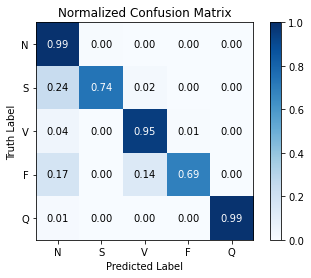

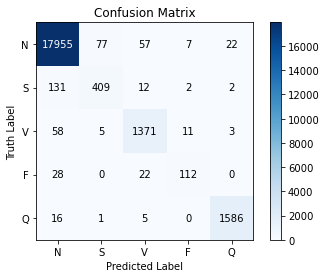

In [18]:
# Get confusion matrix of the results. 
cm = confusion_matrix(new_labels, model_preds)
cm_norm = cm / cm.astype(float).sum(axis=1)[:,np.newaxis]

# Plot Normalized Confusion Matrix
def plot_confusion_matrix(new_labels, model_preds, filepath):
    cm = confusion_matrix(new_labels, model_preds)
    cm_norm = cm / cm.astype(float).sum(axis=1)[:,np.newaxis]

    # Plot Normalized Confusion Matrix
    fig, ax = plt.subplots()
    cax = ax.matshow(cm_norm, cmap='Blues', vmin=0, vmax=1)
    for (i,j), z in np.ndenumerate(cm_norm):
        if z > 0.5:
            ax.text(j, i, '{:.2f}'.format(z), ha='center', va='center', color='w')
        else:
            ax.text(j, i, '{:.2f}'.format(z), ha='center', va='center')
    fig.colorbar(cax)
    labels = ['','N','S','V','F','Q']

    ax.set_title('Normalized Confusion Matrix')
    ax.set_ylabel('Truth Label')
    ax.set_xlabel('Predicted Label')

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.xaxis.set_ticks_position('bottom')

    fig.savefig(filepath+'Normalized_Confusion_Matrix.png')

    # Plot Confusion Matrix
    cm_max = np.max(cm)
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap='Blues')
    for (i,j), z in np.ndenumerate(cm):
        if z > cm_max/2:
            ax.text(j, i, '{:.0f}'.format(z), ha='center', va='center', color='w')
        else:
            ax.text(j, i, '{:.0f}'.format(z), ha='center', va='center')
    fig.colorbar(cax)
    labels = ['','N','S','V','F','Q']

    ax.set_title('Confusion Matrix')
    ax.set_ylabel('Truth Label')
    ax.set_xlabel('Predicted Label')

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.xaxis.set_ticks_position('bottom')

    fig.savefig(filepath+'Confusion_Matrix.png')
    
plot_confusion_matrix(new_labels, model_preds, filepath)

There is a separate dataset that is separated into only two classes, normal and abnormal. Test model against this other dataset and observe performance.

In [20]:
new_data, new_labels = load_data("./archive/ptbdb_normal.csv")
new_data = np.expand_dims(new_data, axis=2)

predictions = model.predict(new_data)
model_preds = []
for prediction in predictions:
    model_preds.append(np.argmax(prediction))

127/127 [==============================] - 1s 9ms/step


C:\Users\donki\AppData\Local\Temp\ipykernel_9032\1847287773.py:3: RuntimeWarning: invalid value encountered in true_divide
  cm_norm = cm / cm.astype(float).sum(axis=1)[:,np.newaxis]
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\1847287773.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\1847287773.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\1847287773.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\1847287773.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


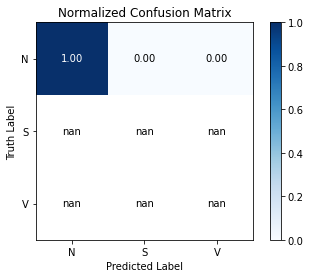

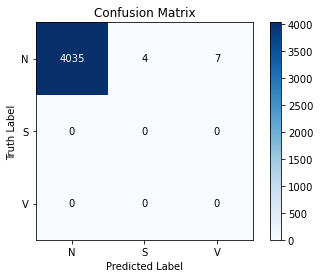

In [21]:
# Get confusion matrix of the results. 
plot_confusion_matrix(new_labels, model_preds, filepath)

All things considered, the model performs quite well against the second dataset. How well does it perform against the abnormal data of the other dataset?

In [22]:
new_data, new_labels = load_data("./archive/ptbdb_abnormal.csv")
new_data = np.expand_dims(new_data, axis=2)

predictions = model.predict(new_data)
model_preds = []
for prediction in predictions:
    model_preds.append(np.argmax(prediction))

329/329 [==============================] - 3s 8ms/step


In [15]:
print(Counter(model_preds))

Counter({0: 9617, 2: 437, 4: 285, 1: 164, 3: 3})


C:\Users\donki\AppData\Local\Temp\ipykernel_9032\1847287773.py:3: RuntimeWarning: invalid value encountered in true_divide
  cm_norm = cm / cm.astype(float).sum(axis=1)[:,np.newaxis]
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\1847287773.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\1847287773.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\1847287773.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\1847287773.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


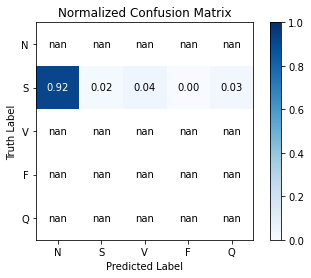

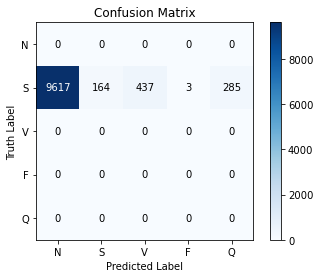

In [23]:
# Get confusion matrix of the results. 
plot_confusion_matrix(new_labels, model_preds, filepath)

Judging from the performance of the abnormal heartbeat data, the model is classifying most of these inputs as Normal heartbeats. It appears likely that the model has overfit to the Normal heartbeat class.


Now check performance when training against a balanced dataset.

In [ ]:
# Load in model
input_shape = (187,1) # Number of channels per input is 1
num_classes = len(np.unique(data1_labels))
num_blocks  = 3

model = stanford_resnet(input_shape, num_classes, 3)
print(model.summary())

In [ ]:
# Train model on second configuration
filepath = './model2/'
if not os.path.exists(filepath):
    os.makedirs(filepath)

X = np.expand_dims(data1_reduced, axis=2)
y = tf.keras.utils.to_categorical(data1_labels_reduced, num_classes=5, dtype='int')

# Split data into Train/Validation/Test sets [80/10/10]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test     = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

# Train model
checkpoint_path = filepath+'model.{epoch:02d}-{val_loss:.2f}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy')
history = model.fit(X_train, y_train,
                    batch_size=32, epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[model_checkpoint_callback])
model.save(filepath+'final_model')


# Save history of training
history_dict = history.history
with open(filepath+'history.pkl', 'wb') as handle:
    pickle.dump(history_dict, handle)
    
# Create Acc and Loss plots
plt.figure()
plt.plot(history_dict['loss'])
plt.title('Training Loss')
plt.savefig(filepath+'Loss_Plot.png')
plt.show()

plt.figure()
plt.plot(history_dict['accuracy'])
plt.title('Training Acc')
plt.savefig(filepath+'Acc_Plot.png')
plt.show()

Performance currently looks a little worse than the first set of data.

In [24]:
# Get accuracy against the saved test set
model = tf.keras.models.load_model('./model2/final_model')
performance = model.evaluate(X_test, y_test)
print('Test Loss: {:.2f} | Test Acc: {:.2f}'.format(performance[0], performance[1]))

69/69 [==============================] - 1s 8ms/step - loss: 1.0079 - accuracy: 0.6196
Test Loss: 1.01 | Test Acc: 0.62


Test split data is also not performancing as well.

In [25]:
new_data, new_labels = load_data("./archive/mitbih_test.csv")
new_data = np.expand_dims(new_data, axis=2)

predictions = model.predict(new_data)
model_preds = []
for prediction in predictions:
    model_preds.append(np.argmax(prediction))

685/685 [==============================] - 6s 8ms/step


C:\Users\donki\AppData\Local\Temp\ipykernel_9032\160333454.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\160333454.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\160333454.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\160333454.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


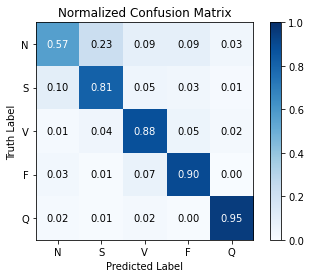

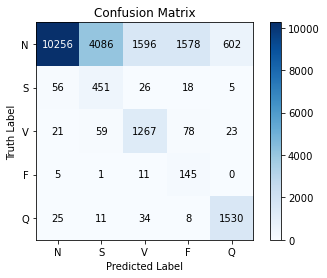

In [27]:
# Get confusion matrix of the results. 
filepath = './model2/'
plot_confusion_matrix(new_labels, model_preds, filepath)

The performance of the model against the balanced dataset has a more even performance against the smaller classes, but the performance against the Normal class is much worse.

Given the nature of this problem, the performance of this model might actually be preferrable. (Normal heartbeats classified as anomalous heartbeats is preferrable to classifying an anomalous heartbeat as a normal one)  but an ideal case would have improved performance across all classes.

Again, test this model against the normal and abnormal heartbeat data from the secondary datasets.


127/127 [==============================] - 1s 8ms/step


C:\Users\donki\AppData\Local\Temp\ipykernel_9032\837698304.py:14: RuntimeWarning: invalid value encountered in true_divide
  cm_norm = cm / cm.astype(float).sum(axis=1)[:,np.newaxis]
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\837698304.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\837698304.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\837698304.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\837698304.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


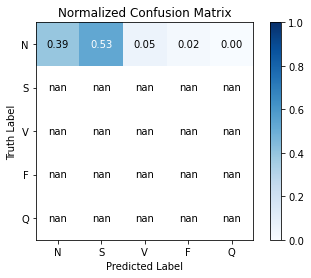

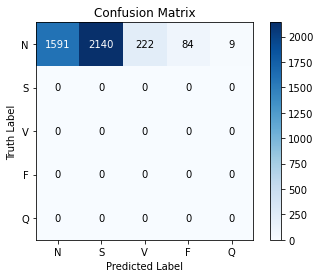

In [29]:
new_data, new_labels = load_data("./archive/ptbdb_normal.csv")
new_data = np.expand_dims(new_data, axis=2)

predictions = model.predict(new_data)
model_preds = []
for prediction in predictions:
    model_preds.append(np.argmax(prediction))
    
# Get confusion matrix of the results. 
filepath = './model2/'
    
plot_confusion_matrix(new_labels, model_preds, filepath)

Performance against the normal data looks consistent with the performance seen against the original dataset's test data.

329/329 [==============================] - 3s 8ms/step


C:\Users\donki\AppData\Local\Temp\ipykernel_9032\837698304.py:14: RuntimeWarning: invalid value encountered in true_divide
  cm_norm = cm / cm.astype(float).sum(axis=1)[:,np.newaxis]
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\837698304.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\837698304.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\837698304.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_9032\837698304.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


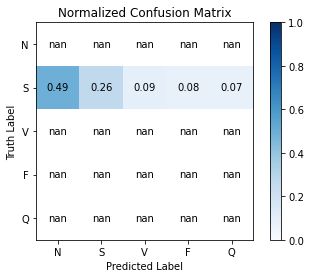

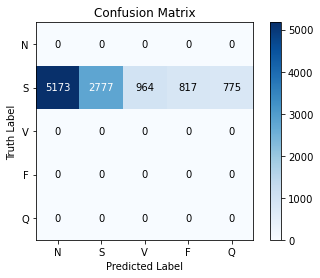

In [30]:
new_data, new_labels = load_data("./archive/ptbdb_abnormal.csv")
new_data = np.expand_dims(new_data, axis=2)

predictions = model.predict(new_data)
model_preds = []
for prediction in predictions:
    model_preds.append(np.argmax(prediction))
    
# Get confusion matrix of the results. 
filepath = './model2/'
    
plot_confusion_matrix(new_labels, model_preds, filepath)

Performance against the abnormal dataset looks better than the performance shown by the first model, with fewer false alarms. It would seem that this model has generalized better to heartbeats overall, but there is still a significant number of inputs that are being classified as normal heartbeats.

As it stands, both models will require more work to be more robust against a wider range of data.